# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [2]:
from top2vec import Top2Vec

import os
import spacy
import unidecode
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


2023-01-15 20:29:26.552507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 20:29:26.935631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-15 20:29:26.935664: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-15 20:29:28.446516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Data and sources


## Prints for Koppermaandag
From the 18th century onwards, so called "Koppermaandagprenten" are retained in cultural heritage institutes. These prints are a proof of the quality of printing that a printshop was able to deliver. The labourers of a printshop made a print and brought them to the customers, expecting them to buy the print, or give a tip. This extra income was used to buy drinks on "Koppermaandag", a celebration on the first Monday after Epiphany.

In 1991, an important publication is made about this type of printwork, with an overview of the retained Koppermaandagprenten. From this book the counts per year are available.

In [3]:
prentenDF = pd.read_csv("data/koppermaandagprentenCount.csv", index_col="year")

print("Number of prints: "+ str(prentenDF['count'].sum()))


Number of prints: 554


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [4]:
liedjesDF = pd.read_csv("data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    759
Number of booklets:  63


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [5]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.lower().split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [6]:
liedjesFilenames    = getlistOfFilenames('data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee", "immer", "t", "d", "wijze", "hurah"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [49]:
n = 106

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                             amsterdam1849
sourceID                         amsterdam1849-feestliederen1863
songID                        amsterdam1849-feestliederen1863-04
titel                   Hulde en dank aan het werkend gezelschap
wijze                                     Marchand de parapluies
jaartal                                                     1863
schrijver                                        R. van der Star
vereniging_schrijver                               amsterdam1849
wordcount                                                     77
topic                                                          0
topic_score                                             0.949435
topic0                                                       0.0
topic1                                                       0.0
topic2                                                  0.059549
Name: 170, dtype: object
-- path: --
data/lyrics/amsterdam1849/amsterdam1849-f

# Count 
The development of the number of particular retained heritage of printing in the nineteenth century might say something about the change of relevance for printers to create these prints. In this notebook the development of printing heritage is investigated.



## Number of Koppermaandagprenten per year
First, we study the number of Koppermaandagprenten per year. We smooth the count with a five year rolling mean. We observe two timeperiods where the making of these prints was popular: the 1820's and between 1840-1860.

<AxesSubplot: xlabel='year'>

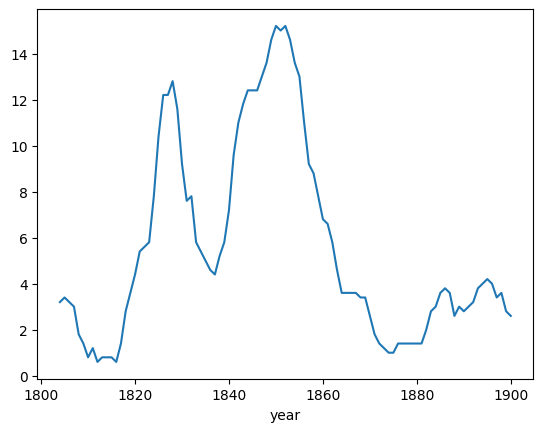

In [8]:
prentenDF['count'].rolling(5).mean().plot()

## Number of songs and number of words per year
Secondly, we want to investigate how much songs are in the dataset per year. We smooth the outcome again with a five years rolling mean. We observe a popularity for creating songs between 1850 en 1865.

<AxesSubplot: xlabel='jaartal'>

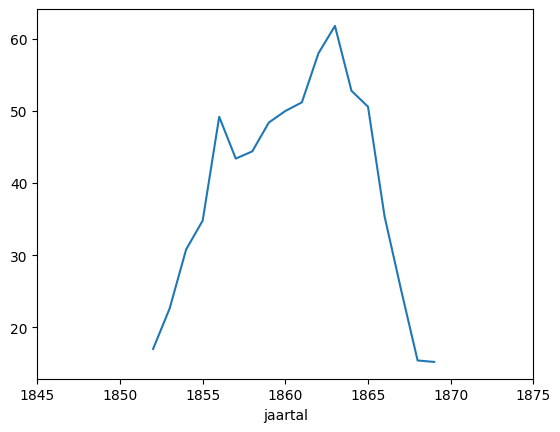

In [9]:
liedjesDF.groupby('jaartal').size().rolling(5).mean().plot(xlim=(1845,1875))

We study the number of words per year, instead of the number of songs per year for a potentially more precise indication. We calculate the number of words per song and add this to the liedjes DataFrame.

(array([ 0.,  0.,  2.,  3.,  3.,  5.,  9., 17., 21., 41., 31., 63., 73.,
        79., 54., 43., 41., 43., 43., 28., 35., 16., 19., 23., 14., 13.,
         5., 11.,  4.,  4.,  2.,  2.,  0.,  3.,  3.,  0.,  1.,  0.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195.]),
 <BarContainer object of 39 artists>)

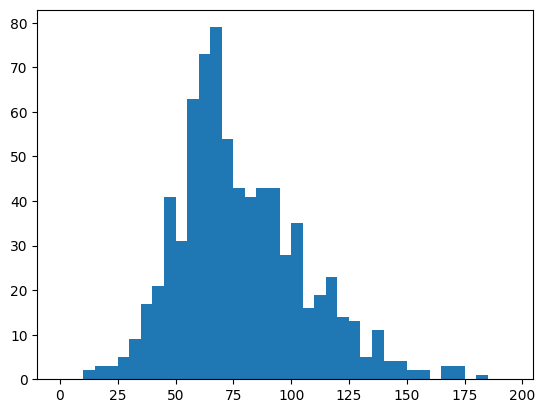

In [10]:
numberOfSongs = len(liedjes)

listOfWordlists = [] 
for i in range(0,numberOfSongs): listOfWordlists.append(preprocessedLiedjes[i].split())

listOfWordcounts = []
for i in range(0,numberOfSongs): listOfWordcounts.append(len(listOfWordlists[i]))

plt.hist(listOfWordcounts, bins=range(0,200,5), range=[0,200])


In [11]:
liedjesDF['wordcount'] = listOfWordcounts
liedjesDF.iloc[n]


typoID                                                      amsterdam1849
sourceID                                  amsterdam1849-feestliederen1862
songID                                 amsterdam1849-feestliederen1862-06
titel                   De boekdrukkunst beschouwd als het licht der v...
wijze                                   Makkers brengt met stem en snaren
jaartal                                                              1862
schrijver                                                        H. Stühr
vereniging_schrijver                                        amsterdam1849
wordcount                                                              89
Name: 164, dtype: object

<AxesSubplot: xlabel='jaartal'>

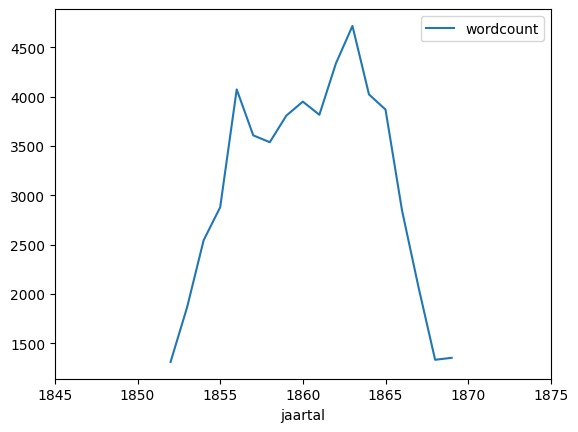

In [12]:
liedjesDF.groupby('jaartal').sum('wordcount').rolling(5).mean().plot(xlim=(1845,1875))

## Average size of a song per year
So the number of songs and the total number of words in the lyrics per year does not differ that much. How about the average size of a song per year? 

<AxesSubplot: xlabel='jaartal'>

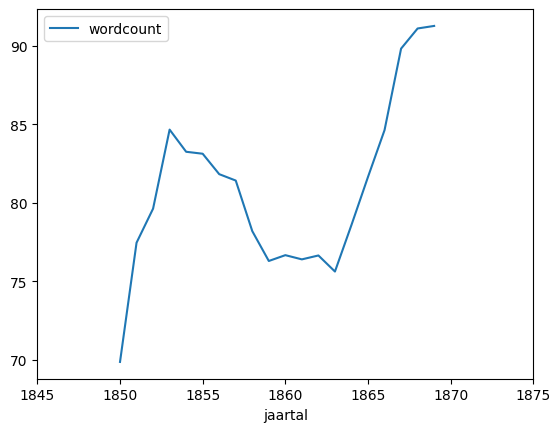

In [13]:
liedjesDF.groupby('jaartal').mean('wordcount').rolling(3).mean().plot(xlim=(1845,1875))

## Number of booklets per year
The number of booklets per year. Some booklets contain larger collections of songs through time of one typographical association (Middelburg) or of various associations on one moment (on the occasion of the erection of the statue of Coster in Haarlem 1856). We create a slice of the DataFrame without these books (with more than 50 songs) to have a better overview of the books created by associations in their own reasons. For the same reason we remove from this slice the singular songs that are retained over time (so we select booklets we at least 3 songs).

<AxesSubplot: xlabel='year'>

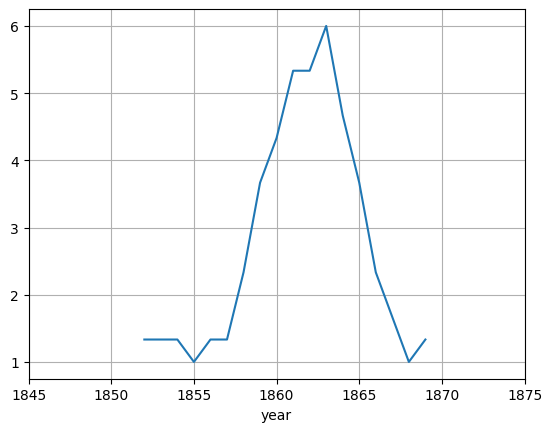

In [14]:
boekjesDF    = pd.read_csv('data/boekjes.csv')
boekjesSlice = boekjesDF.loc[boekjesDF['size'] < 50].loc[boekjesDF['size'] > 2]
boekjesSlice.groupby('year').size().rolling(3).mean().plot(xlim=(1845,1875), grid=True)

## Compare the number of Koppermaandagprenten with the number of songs

<AxesSubplot: xlabel='year'>

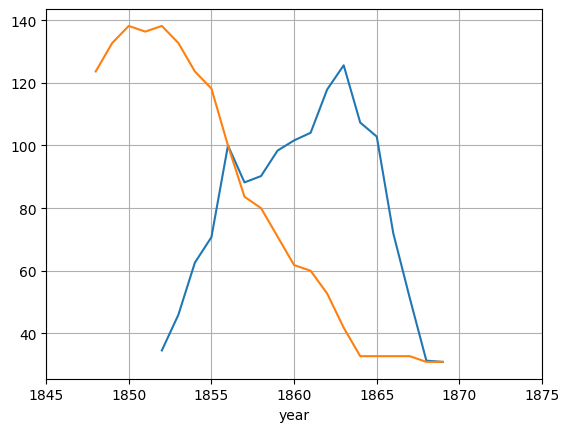

In [15]:
liedjesSerie = liedjesDF.groupby('jaartal').size().rolling(5).mean()
prentenSerie = prentenDF['count'].rolling(5).mean()

baseYear = 1856

indexCijfersLiedjes = []
for year in range(1848,1870): indexCijfersLiedjes.append((liedjesSerie.loc[year] / liedjesSerie.loc[baseYear]) * 100)

indexCijfersPrenten = []
for year in range(1848,1870): indexCijfersPrenten.append((prentenSerie.loc[year] / prentenSerie.loc[baseYear]) * 100)

indexCijfersDF = pd.DataFrame()
indexCijfersDF['year'] = range(1848,1870)
indexCijfersDF['liedjesIndex'] = indexCijfersLiedjes
indexCijfersDF['prentenIndex'] = indexCijfersPrenten

indexCijfersDF = indexCijfersDF.set_index('year')
indexCijfersDF['liedjesIndex'].plot(xlim=(1845,1875), grid=True)
indexCijfersDF['prentenIndex'].plot(xlim=(1845,1875), grid=True)




## Average size of booklets per year, in number of songs and number of words

# Topics with Top2Vec
Do the topics of songs change over time?

In [16]:
model = Top2Vec(preprocessedLiedjes)

2023-01-15 20:30:16,403 - top2vec - INFO - Pre-processing documents for training
2023-01-15 20:30:16,632 - top2vec - INFO - Creating joint document/word embedding
2023-01-15 20:30:19,616 - top2vec - INFO - Creating lower dimension embedding of documents
2023-01-15 20:30:41,471 - top2vec - INFO - Finding dense areas of documents
2023-01-15 20:30:41,506 - top2vec - INFO - Finding topics


In [17]:
model.topic_sizes

0    637
1    122
dtype: int64

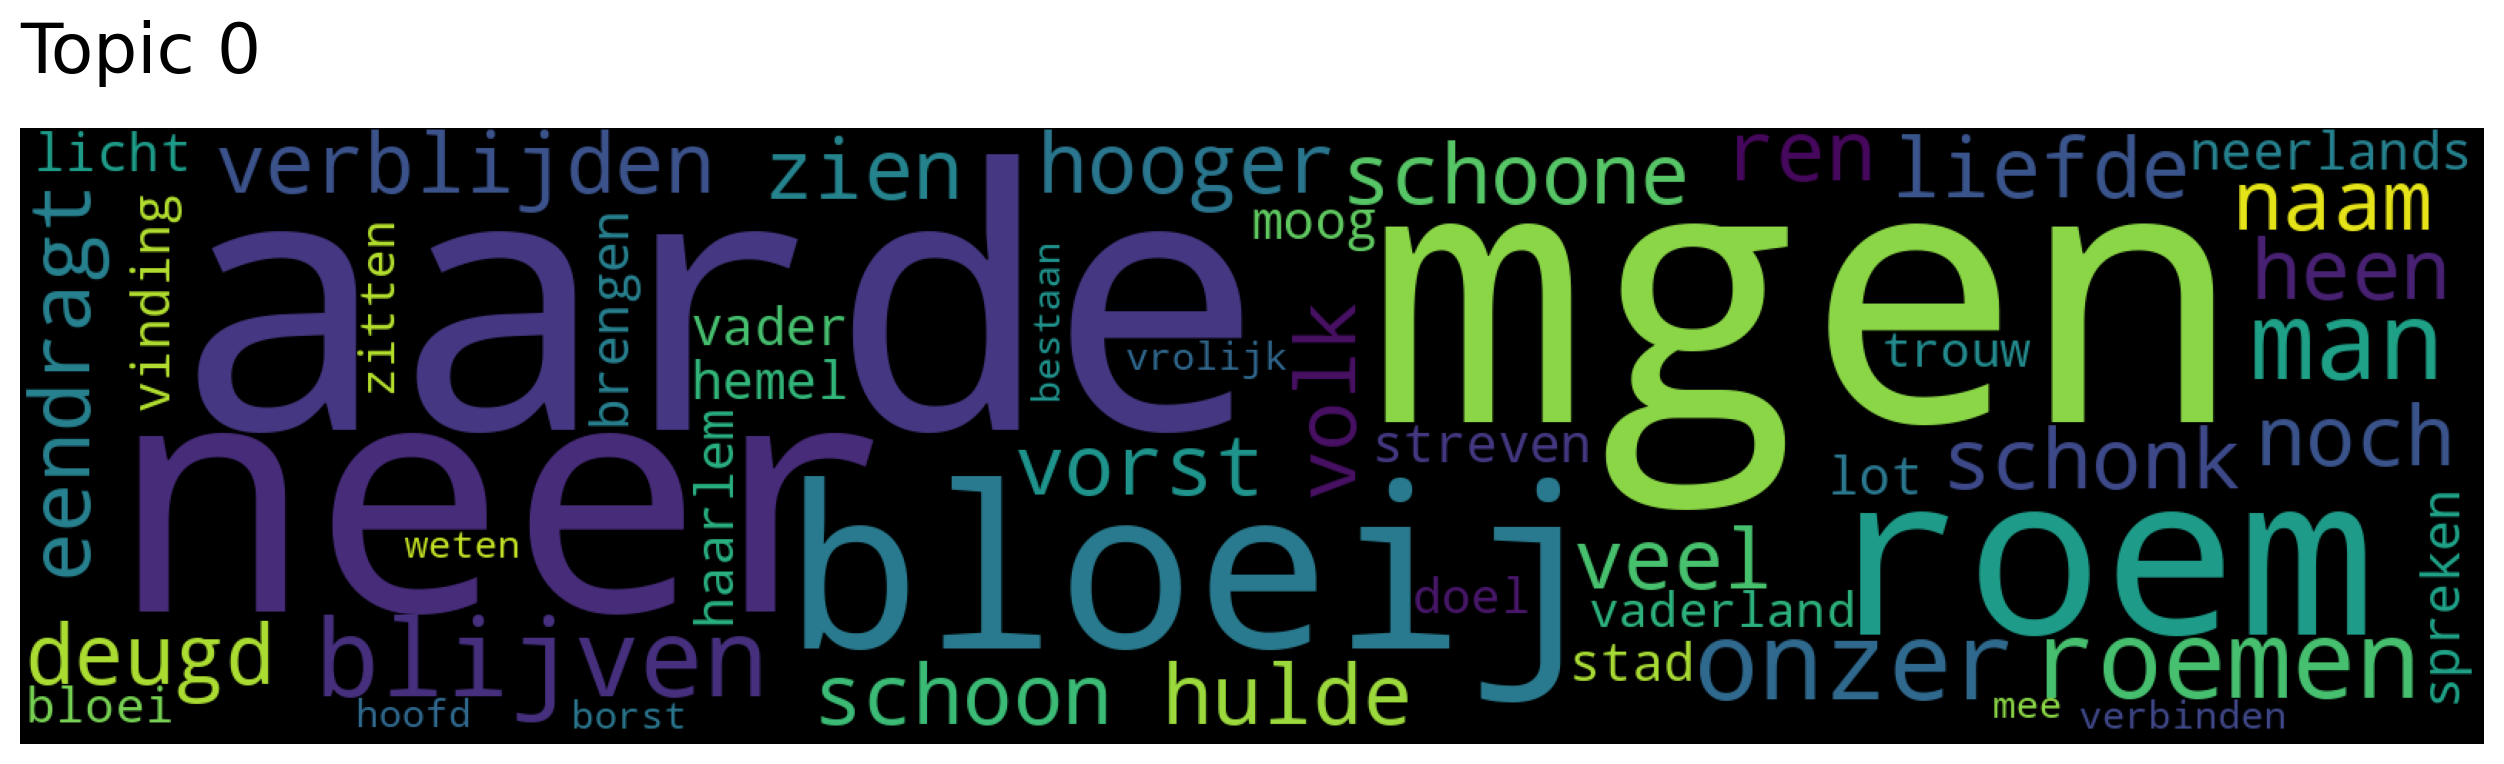

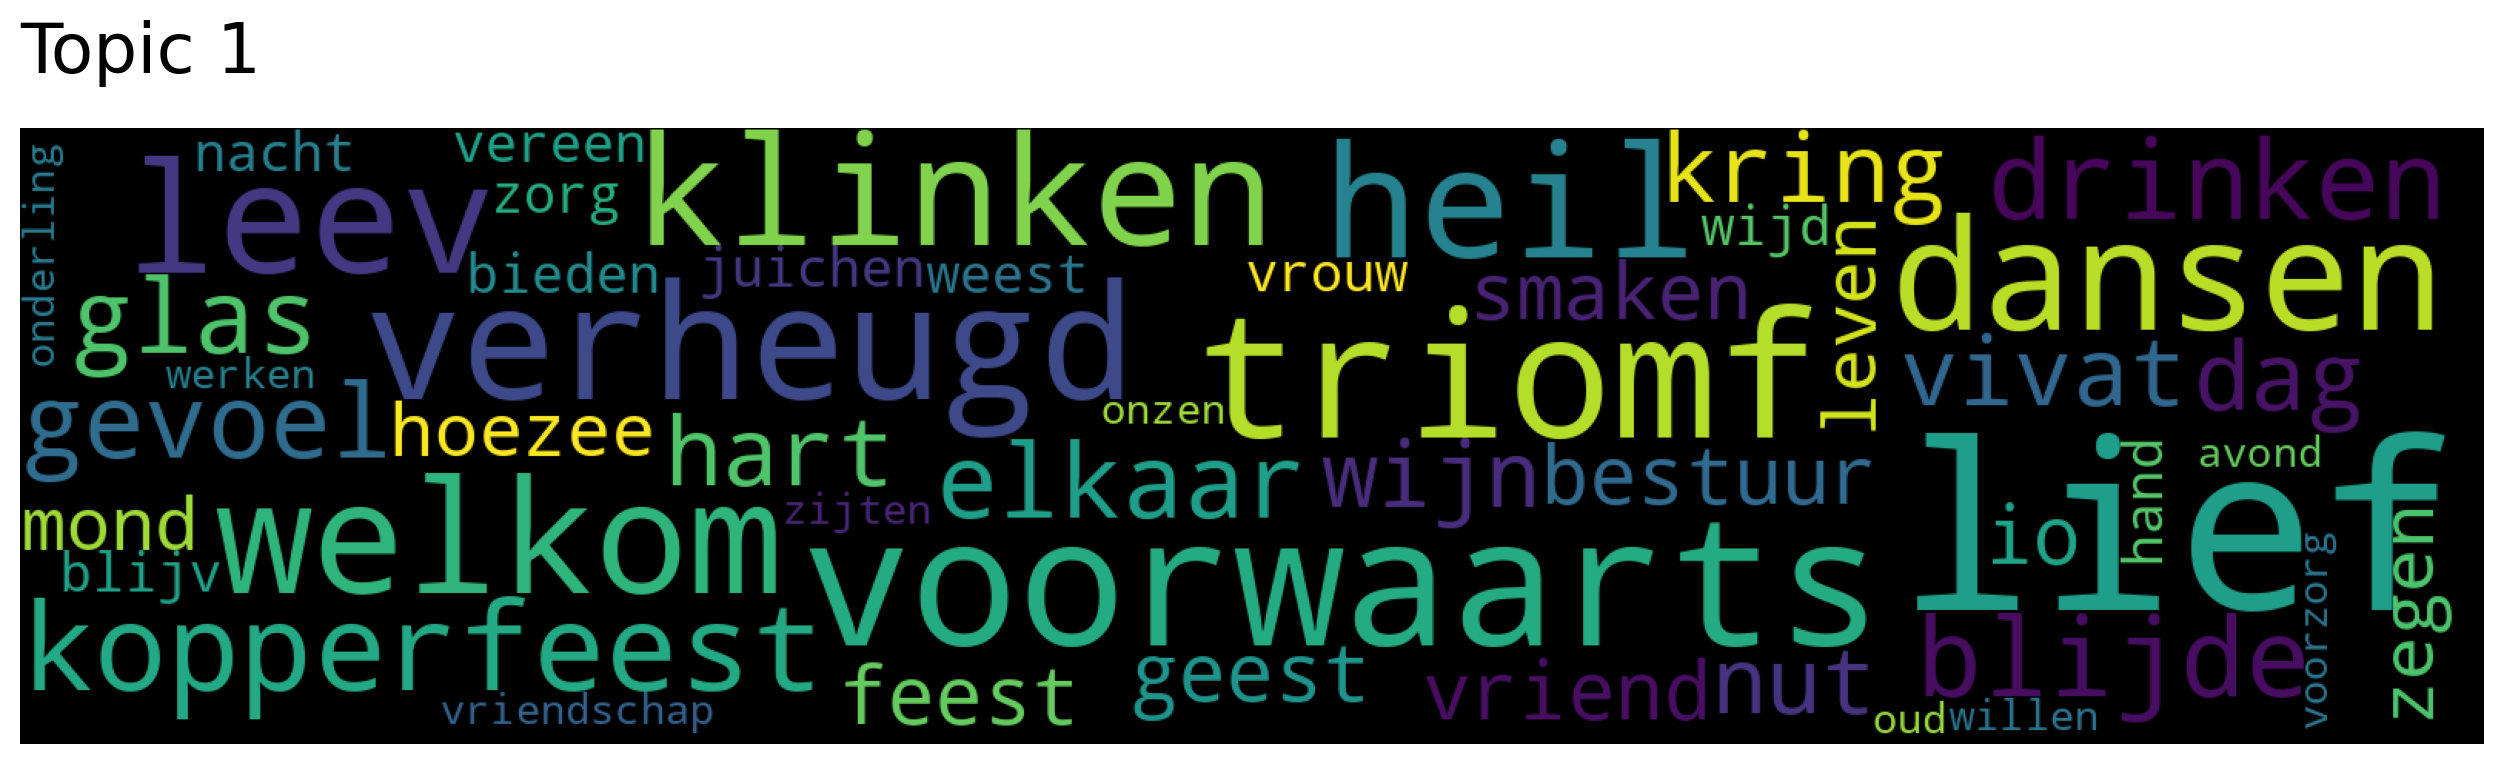

In [18]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [19]:
model.get_documents_topics([8])

(array([0]),
 array([0.6870618], dtype=float32),
 array([['aarde', 'mgen', 'neer', 'bloeij', 'roem', 'blijven', 'onzer',
         'man', 'roemen', 'verblijden', 'veel', 'hooger', 'deugd',
         'schoon', 'naam', 'ren', 'schonk', 'liefde', 'zien', 'noch',
         'hulde', 'vorst', 'schoone', 'eendragt', 'volk', 'heen',
         'neerlands', 'moog', 'hemel', 'lot', 'streven', 'vinding',
         'stad', 'brengen', 'haarlem', 'licht', 'spreken', 'vader',
         'vaderland', 'doel', 'zitten', 'bloei', 'trouw', 'vrolijk',
         'weten', 'mee', 'borst', 'bestaan', 'hoofd', 'verbinden']],
       dtype='<U11'),
 array([[0.99740434, 0.9970796 , 0.9968222 , 0.99675685, 0.9963371 ,
         0.9961978 , 0.9961848 , 0.99606526, 0.99582046, 0.9957308 ,
         0.99564606, 0.99552083, 0.99551624, 0.9954884 , 0.9954277 ,
         0.9954166 , 0.9952065 , 0.99514633, 0.9951263 , 0.99495816,
         0.9949201 , 0.9947242 , 0.9945317 , 0.99447   , 0.99446875,
         0.99441916, 0.994409  , 0.

In [20]:
doc_ids = list(range(0, len(liedjesDF)))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

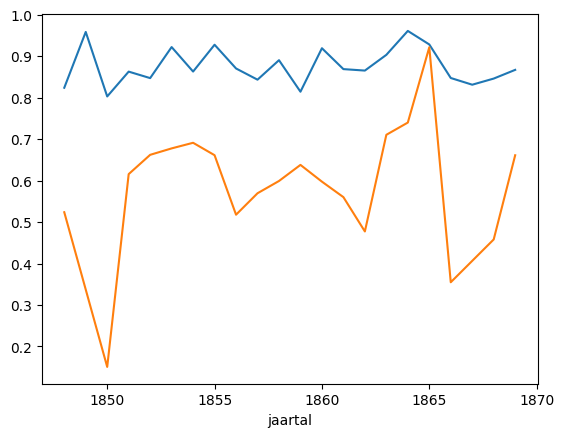

In [21]:
for topic in topic_nums:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    dfAvg['topic_score'].plot()


# Handmade topics
* nationalism: ["willem", "vaderland", "coster"]
* relation with patrons: ["donateur", "ereleden"]
* grievances ["loon", "zegel"]

In [22]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

def listify(listOfTexts):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.split()
        result.append(liedje)

    return result

def topics2vectors(topicList, vocabulary):
    result = []
    for topic in topicList:
        topicVector = []
        for term in vocabulary:
            if term in topic:
                topicVector.append(1)
            else:
                topicVector.append(0)
        result.append(topicVector)

    return result


In [23]:
listifiedLiedjes = listify(preprocessedLiedjes)
liedjesVocabulary = extract_vocabulary(listifiedLiedjes, min_count=2)
dtmLiedjes = np.array(corpus2dtm(listifiedLiedjes, liedjesVocabulary))

len(liedjesVocabulary)

4154

In [116]:
topic0 = ['nederland',  'holland',  'nederlandsch', 'nederlandsche', 'nederlandschen', 'hollandsch', 'hollandsche', 'hollandschen', 'nederlands', 'nederlandse', 'nederlandsen', 'hollands', 'hollandse', 'hollandsen', 'neerlands', 'neerlandse', 'neerlandsen', 'geboortegrond',  'geboorteland',  'moederland',  'patria', 'vaderland', 'held', 'landgenoot']
topic1 = ['eereleden', 'beschermheer', 'donateurs', 'baas', 'patroon', 'patronen', 'burgervader', 'heeren', 'honorair', 'hooggeachte']
topic2 = ['koning', 'vorst', 'willem']
topicList = [topic0, topic1, topic2]
topicVectors = np.array(topics2vectors(topicList, liedjesVocabulary))

In [117]:
for j in range(len(topicVectors)):
    topic = "topic" + str(j)
    b = topicVectors[j]
    distances = []
    for i in range(len(liedjesDF)):
        a = dtmLiedjes[i]
        if np.linalg.norm(a) > 0:
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        else:
            cos_sim = 0.0
        distances.append(cos_sim)
    liedjesDF[topic] = distances


In [73]:
n = 200

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- song: --")
print(liedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                      amsterdam1857-1
sourceID                   amsterdam1857-1-feestbundel1862b
songID                  amsterdam1857-1-feestbundel1862b-06
titel                                       Typographenlied
wijze                    Eens werd er aan de zeeuwsche kust
jaartal                                                1862
schrijver                                         I. Poster
vereniging_schrijver                        amsterdam1857-1
wordcount                                                81
topic                                                     0
topic_score                                        0.975695
topic0                                             0.116297
topic1                                                  0.0
topic2                                                  0.0
Name: 264, dtype: object
-- song: --
Typographen-lied

Eens zag men in de Spaarnestad
Een groot genie verrijzen ;
Dat 't nakroost hem ook niet verga

/tmp/ipykernel_3692/2646426346.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = liedjesDF.groupby('jaartal').mean().rolling(3).mean()


<AxesSubplot: xlabel='jaartal'>

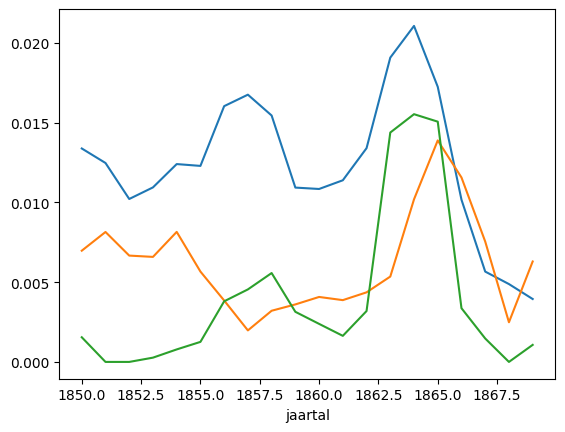

In [118]:
df = liedjesDF.groupby('jaartal').mean().rolling(3).mean()
df['topic0'].plot()
df['topic1'].plot()
df['topic2'].plot()